In [21]:
# import summary
from torchsummary import summary
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from milesial_unet import UNet
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Example validation accuracies (replace with actual values)
model1_accuracies = [0.45, 0.48, 0.49]
model2_accuracies = [0.50, 0.45, 0.47]

# Shapiro-Wilk test for normality
stat1, p1 = shapiro(model1_accuracies)
stat2, p2 = shapiro(model2_accuracies)

print('Model 1: Statistics=%.3f, p=%.3f' % (stat1, p1))
print('Model 2: Statistics=%.3f, p=%.3f' % (stat2, p2))

if p1 > 0.05 and p2 > 0.05:
    print('Both samples look Gaussian (fail to reject H0)')
    # Paired t-test
    t_stat, p_val = ttest_rel(model1_accuracies, model2_accuracies)
    print('Paired t-test: t=%.3f, p=%.3f' % (t_stat, p_val))
else:
    print('At least one sample does not look Gaussian (reject H0)')
    # Wilcoxon signed-rank test
    w_stat, p_val = wilcoxon(model1_accuracies, model2_accuracies)
    print('Wilcoxon test: W=%.3f, p=%.3f' % (w_stat, p_val))

if p_val < 0.05:
    print('Statistically significant difference')
else:
    print('No statistically significant difference')


ValueError: Data must be at least length 3.

In [4]:
fold_metrics = {'fold_0': {'train_loss': 0.5097101352612178, 'val_loss': 0.5430395682652791}, 
                'fold_1': {'train_loss': 0.5133466015259425, 'val_loss': 0.5446163614590963}, 
                'fold_2': {'train_loss': 0.5096749768654505, 'val_loss': 0.5431361289819082}}
# get the fold key with the lowest validation loss
best_fold = min(fold_metrics, key=lambda k: fold_metrics[k]['val_loss']).split('_')[1]
print(best_fold)


0


In [3]:
best = min(fold_metrics, key=fold_metrics.get)

TypeError: '<' not supported between instances of 'dict' and 'dict'

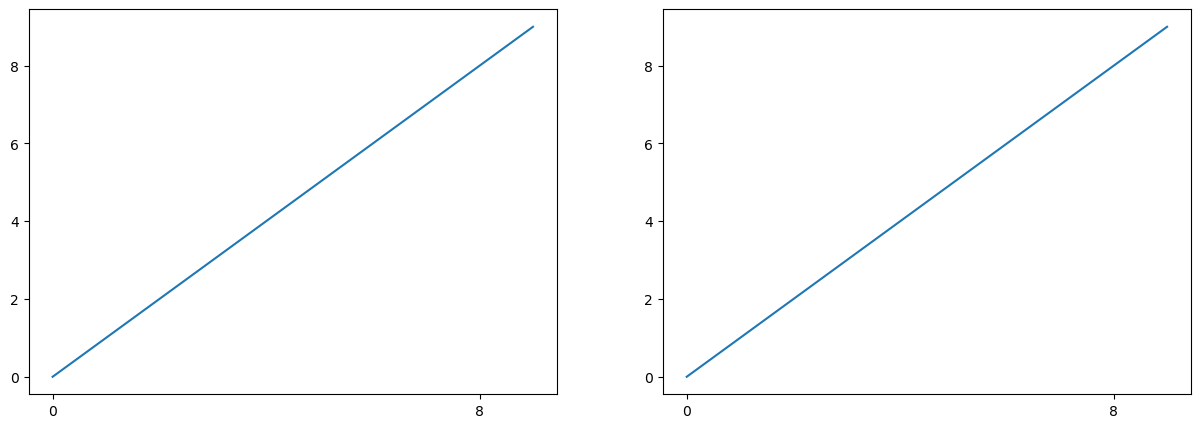

In [28]:
# testing matplotlib set_xticks
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(10), range(10))
axs[1].plot(range(10), range(10))
# set step 2 for both plots
for ax in axs:
    ax.set_xticks(np.arange(0, 10, step=8))

### Comparison of milesial unet and SMP unet

In [16]:
unet_m = UNet(n_channels=10, n_classes=10)
unet_s = smp.Unet(encoder_name= 'resnet50', encoder_weights=None, in_channels=10, classes=10)


In [12]:
# comparing summaries
print('Milesial UNet')
summary(unet_m, (10, 256, 256))


Milesial UNet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           5,760
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14     

In [17]:
print('Segmentation Models Pytorch UNet')
summary(unet_s, (10, 256, 256))

Segmentation Models Pytorch UNet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          31,360
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      

**Note:** If you see, there's a major difference in the number of trainable parameters. Milesial had 30 mil parameters while SMP has 14 mil parameters. This is because of the use of `Resnet18` as the encoder in SMP unet.

In [23]:
model_a = smp.Unet(encoder_weights = None, in_channels =10, classes = 5, add_reconstruction_head=True)
model_b = smp.Unet(encoder_weights = None, in_channels =10, classes = 5, add_reconstruction_head=True)
#model_a2 = smp.Unet(encoder_weights = None, in_channels =3, classes = 5 )

In [24]:
# sum of weights
temp_model = smp.Unet(encoder_weights = None, in_channels =10, classes = 5, add_reconstruction_head=False)

In [32]:
a = model_a.encoder.state_dict()
b = model_b.encoder.state_dict()
c = temp_model.encoder.state_dict()
for i in c:
    c[i] = (a[i] + b[i])/2

In [36]:
d= smp.Unet(encoder_weights = None, in_channels =10, classes = 5, add_reconstruction_head=False)
d.encoder.load_state_dict(c)

In [37]:
for i in d.encoder.parameters():
    print(i[0][0])
    break
for i in model_a.encoder.parameters():
    print(i[0][0])
    break
for i in model_b.encoder.parameters():
    print(i[0][0])
    break

tensor([[-2.5504e-03,  1.3099e-03, -9.0313e-03, -1.2774e-02, -1.6580e-02,
         -2.3181e-03, -2.1028e-02],
        [ 1.9606e-02, -1.6555e-03, -4.8861e-03,  3.7449e-02, -2.8395e-02,
          1.5006e-02, -3.0219e-02],
        [-9.2350e-03, -3.4425e-03, -1.9886e-02, -2.6173e-02,  6.9705e-03,
         -3.0422e-02,  8.1734e-03],
        [ 4.3664e-03, -2.4689e-02,  7.7594e-03,  3.6499e-05, -2.3412e-02,
          8.2842e-03,  1.2254e-02],
        [-2.0060e-02,  1.9321e-02, -2.3938e-02,  2.6235e-03, -5.6517e-03,
          2.9064e-02, -4.2669e-02],
        [ 1.3119e-02,  2.5382e-02, -2.7725e-02, -3.7611e-02, -6.9014e-03,
         -9.6965e-03, -1.6031e-03],
        [-3.3830e-03,  2.2193e-03, -1.2554e-02,  2.3453e-03, -2.0687e-02,
          1.4804e-02, -2.5015e-02]], grad_fn=<SelectBackward0>)
tensor([[ 0.0173, -0.0231, -0.0250,  0.0007,  0.0035, -0.0306, -0.0161],
        [-0.0001,  0.0231, -0.0273,  0.0375, -0.0317,  0.0016, -0.0200],
        [-0.0144,  0.0155, -0.0098, -0.0330,  0.0114, -0

In [3]:
for i in model_a.encoder.parameters():
    print(i[0][0])
    break

tensor([[-0.0010, -0.0243,  0.0213,  0.0437, -0.0288,  0.0357,  0.0054],
        [-0.0111,  0.0035,  0.0258, -0.0231, -0.0316,  0.0379,  0.0414],
        [ 0.0195, -0.0025,  0.0408,  0.0398, -0.0137, -0.0020, -0.0425],
        [ 0.0385,  0.0387,  0.0026, -0.0328, -0.0381, -0.0309,  0.0351],
        [-0.0183,  0.0185, -0.0439,  0.0391, -0.0397, -0.0308, -0.0062],
        [-0.0275, -0.0409, -0.0163,  0.0205, -0.0154, -0.0269,  0.0187],
        [-0.0065, -0.0433, -0.0325,  0.0419, -0.0087,  0.0232,  0.0261]],
       grad_fn=<SelectBackward0>)


In [4]:
for i in model_b.encoder.parameters():
    print(i[0][0])
    break

tensor([[-0.0164, -0.0293, -0.0260,  0.0436,  0.0218,  0.0094,  0.0306],
        [-0.0254, -0.0030, -0.0282,  0.0344,  0.0202,  0.0148,  0.0320],
        [ 0.0326,  0.0392,  0.0247,  0.0225, -0.0286, -0.0133,  0.0133],
        [ 0.0215, -0.0220,  0.0153, -0.0337, -0.0163,  0.0006, -0.0273],
        [ 0.0295,  0.0208, -0.0440,  0.0379, -0.0165,  0.0316,  0.0146],
        [ 0.0194,  0.0312, -0.0394,  0.0285,  0.0095,  0.0185, -0.0217],
        [ 0.0258,  0.0385, -0.0404,  0.0220, -0.0330,  0.0100, -0.0382]],
       grad_fn=<SelectBackward0>)


In [38]:
u = [1,2,3]
u.

AttributeError: 'list' object has no attribute 'item'

In [17]:
# create a new encoder for a new model_c with averaged weights from encoders of model_a and model_b
model_c = smp.Unet(encoder_weights = None, in_channels =10, classes = 5, add_reconstruction_head=False)

# averaging the weights of the encoders of model_a and model_b
for model_a_layer, model_b_layer, model_c_layer in zip(model_a.encoder.parameters(), model_b.encoder.parameters(), model_c.encoder.parameters()):
    model_c_layer.data = (model_a_layer.data + model_b_layer.data)/2
    print(model_c_layer.data)
# check if the weights of the encoders of model_a and model_b are the same as the weights of the encoder of model_c

tensor([[[[ 2.3335e-03, -1.6482e-02, -1.7181e-02,  ..., -2.1378e-02,
            2.0893e-02,  5.9854e-03],
          [ 2.1225e-02, -9.9324e-03, -1.8733e-02,  ...,  1.0441e-02,
            2.8230e-02,  1.5728e-03],
          [-3.8817e-03, -2.6315e-02, -1.4606e-02,  ..., -4.9458e-03,
            3.0368e-02, -1.7078e-03],
          ...,
          [ 2.2251e-02,  1.3740e-02, -1.1287e-03,  ...,  6.2923e-03,
           -1.5192e-02,  1.0463e-02],
          [ 2.3509e-02, -3.2039e-02,  2.2361e-02,  ...,  6.3201e-03,
           -2.0825e-02,  9.6442e-03],
          [ 6.4910e-03,  4.4815e-03,  2.4994e-02,  ..., -2.1047e-02,
            2.5221e-02,  1.9116e-02]],

         [[-4.1738e-03,  6.4233e-03, -1.9323e-02,  ...,  2.6062e-02,
            1.8908e-02, -2.3722e-02],
          [ 2.3607e-02, -1.5610e-02,  9.0338e-03,  ...,  3.6762e-03,
           -3.1159e-02, -1.1614e-02],
          [-2.3812e-02, -2.5580e-03,  8.5319e-03,  ..., -9.7923e-03,
            2.0319e-02, -2.1082e-02],
          ...,
     

In [16]:
for i in model_c.encoder.parameters():
    print(i[0][0])
    break

tensor([[ 0.0023, -0.0165, -0.0172,  0.0342, -0.0214,  0.0209,  0.0060],
        [ 0.0212, -0.0099, -0.0187,  0.0210,  0.0104,  0.0282,  0.0016],
        [-0.0039, -0.0263, -0.0146,  0.0101, -0.0049,  0.0304, -0.0017],
        [-0.0094,  0.0080, -0.0443, -0.0173, -0.0020,  0.0276,  0.0035],
        [ 0.0223,  0.0137, -0.0011, -0.0121,  0.0063, -0.0152,  0.0105],
        [ 0.0235, -0.0320,  0.0224, -0.0197,  0.0063, -0.0208,  0.0096],
        [ 0.0065,  0.0045,  0.0250,  0.0042, -0.0210,  0.0252,  0.0191]],
       grad_fn=<SelectBackward0>)


In [18]:
a = torch.Tensor([[ 0.0251, -0.0150, -0.0116,  0.0364, -0.0391, -0.0027,  0.0186],
        [ 0.0259, -0.0250, -0.0042,  0.0242,  0.0093,  0.0148, -0.0022],
        [ 0.0365, -0.0099, -0.0150, -0.0227, -0.0002,  0.0204, -0.0365],
        [-0.0409, -0.0146, -0.0444, -0.0312,  0.0359,  0.0117,  0.0295],
        [ 0.0222,  0.0112,  0.0295,  0.0008,  0.0047, -0.0027, -0.0031],
        [ 0.0400, -0.0193,  0.0157, -0.0313, -0.0235, -0.0131,  0.0133],
        [ 0.0112, -0.0011,  0.0055, -0.0235, -0.0360,  0.0263,  0.0115]])

b = torch.Tensor([[-0.0204, -0.0180, -0.0228,  0.0321, -0.0036,  0.0445, -0.0066],
        [ 0.0166,  0.0051, -0.0333,  0.0179,  0.0115,  0.0417,  0.0053],
        [-0.0442, -0.0428, -0.0142,  0.0429, -0.0097,  0.0403,  0.0331],
        [ 0.0221,  0.0307, -0.0441, -0.0034, -0.0399,  0.0435, -0.0224],
        [ 0.0223,  0.0163, -0.0318, -0.0250,  0.0078, -0.0277,  0.0240],
        [ 0.0071, -0.0447,  0.0291, -0.0081,  0.0361, -0.0286,  0.0060],
        [ 0.0018,  0.0100,  0.0444,  0.0320, -0.0061,  0.0242,  0.0267]])


In [19]:
c= (a+b)/2
print(c)

tensor([[ 0.0023, -0.0165, -0.0172,  0.0342, -0.0214,  0.0209,  0.0060],
        [ 0.0213, -0.0099, -0.0188,  0.0210,  0.0104,  0.0283,  0.0015],
        [-0.0038, -0.0264, -0.0146,  0.0101, -0.0049,  0.0303, -0.0017],
        [-0.0094,  0.0081, -0.0443, -0.0173, -0.0020,  0.0276,  0.0036],
        [ 0.0223,  0.0137, -0.0012, -0.0121,  0.0062, -0.0152,  0.0104],
        [ 0.0236, -0.0320,  0.0224, -0.0197,  0.0063, -0.0208,  0.0096],
        [ 0.0065,  0.0044,  0.0249,  0.0043, -0.0210,  0.0252,  0.0191]])


In [11]:
model_b = smp.Unet(encoder_weights = None, in_channels =10, classes = 5, add_reconstruction_head=False)

In [12]:
model_b.reconstruction_head

In [6]:
#test random data to see if model runs
tensor_x = torch.rand(2, 10, 512, 512)  # random tensor for 2 samples, 10 bands, 512x512
tensor_y = torch.randint(0, 5, (2, 512, 512))  # random tensor for 2 samples, 512x512

In [7]:
y_cap = model_b(tensor_x)

In [9]:
y_cap[0].shape, y_cap[1].shape

(torch.Size([2, 5, 512, 512]), torch.Size([2, 10, 512, 512]))

In [15]:
len(y_cap)

2

In [29]:
model_b.reconstruction_head

In [7]:
y_cap_ = model_b(tensor_x)
y_cap.shape

torch.Size([2, 5, 512, 512])

In [23]:
y_cap[1].shape, y_cap[0].shape

(torch.Size([2, 10, 512, 512]), torch.Size([2, 5, 512, 512]))

In [3]:
model_a.reconstruction_head

ReconstructionHead(
  (0): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1))
  (1): Identity()
  (2): Sigmoid()
)

In [7]:
model_a.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [3]:
for i in model_a.encoder.parameters():
    print(i[0,0,:])
    break

tensor([[-0.0146,  0.0261, -0.0068,  0.0198,  0.0196, -0.0152,  0.0189],
        [ 0.0161,  0.0146,  0.0262, -0.0216, -0.0138,  0.0124,  0.0305],
        [ 0.0113, -0.0199,  0.0175,  0.0074,  0.0259,  0.0254, -0.0383],
        [-0.0574, -0.0429, -0.0048, -0.0193, -0.0183,  0.0395,  0.0245],
        [ 0.0320, -0.0243, -0.0101, -0.0244,  0.0069, -0.0445, -0.0272],
        [-0.0972,  0.0111,  0.0456, -0.0159,  0.0154,  0.0196, -0.0055],
        [ 0.0119,  0.0100,  0.0001,  0.0053, -0.0542, -0.0411,  0.0133]],
       grad_fn=<SliceBackward0>)


In [4]:
for i in model_a2.encoder.parameters():
    print(i[0,0,:])
    break

tensor([[ 0.0167,  0.0147,  0.0140, -0.0144,  0.0077, -0.0211, -0.0242],
        [ 0.0121,  0.0172, -0.0148, -0.0091, -0.0361,  0.0115, -0.0227],
        [-0.0149,  0.0214, -0.0236,  0.0010, -0.0016,  0.0342,  0.0167],
        [ 0.0040, -0.0174, -0.0271, -0.0479,  0.0022, -0.0087,  0.0322],
        [-0.0225, -0.0134,  0.0023,  0.0273,  0.0222,  0.0321, -0.0450],
        [ 0.0549,  0.0020, -0.0146, -0.0284, -0.0064,  0.0227, -0.0306],
        [ 0.0375, -0.0069,  0.0175,  0.0330,  0.0047, -0.0063, -0.0106]],
       grad_fn=<SliceBackward0>)


In [8]:
for i in model_a2.decoder.parameters():
    print(i[0,0,:])
    break

tensor([[ 0.0251,  0.0241, -0.0101],
        [ 0.0006,  0.0168,  0.0034],
        [ 0.0236, -0.0121, -0.0122]], grad_fn=<SliceBackward0>)


In [9]:
for i in model_a.decoder.parameters():
    print(i[0,0,:])
    break

tensor([[-0.0006, -0.0130,  0.0081],
        [ 0.0021,  0.0201, -0.0294],
        [-0.0211,  0.0055,  0.0057]], grad_fn=<SliceBackward0>)


In [12]:
#set encoder no grad
for param in model_a.encoder.parameters():
    param.requires_grad = False

for i,param in enumerate(model_a.parameters()):
    print(i,param.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 True
109 True
110 True
111

In [6]:
model_a.encoder = model_a2.encoder

In [16]:
for i in model_a.encoder.parameters():
    print(i[0,0,:])
    break


tensor([[ 0.0076,  0.0254, -0.0206,  0.0027,  0.0125, -0.0284,  0.0264],
        [-0.0170, -0.0123,  0.0053, -0.0054, -0.0022, -0.0348,  0.0405],
        [ 0.0194,  0.0017,  0.0015,  0.0048,  0.0316, -0.0491,  0.0072],
        [ 0.0155, -0.0032,  0.0205, -0.0155, -0.0434,  0.0307,  0.0266],
        [ 0.0099,  0.0214, -0.0301,  0.0141, -0.0254, -0.0412,  0.0025],
        [ 0.0058,  0.0112,  0.0258,  0.0082,  0.0155, -0.0276,  0.0088],
        [-0.0188,  0.0008, -0.0379,  0.0572, -0.0082,  0.0056,  0.0285]])


In [15]:
# change final layer of model_a so that i can have a segmentation task output and an autoencoder output
model_a.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [23]:
model_b = UNet(n_channels=3, n_classes=11)

model_b2 = UNet(n_channels=3, n_classes=11)

In [24]:
# load model
ckpt = torch.load(r'E:\Thesis\outputs\43829_siam18\model_outputs\fold_0_best_model.pth', map_location=torch.device('cpu'))
model_b.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [51]:
# copy weights from pretrained model to new model for encoder
for name, param in model_b.named_parameters():
    if 'inc' in name or 'down' in name:
        print(name)
        model_b2.state_dict()[name].copy_(param)

inc.double_conv.0.weight
inc.double_conv.1.weight
inc.double_conv.1.bias
inc.double_conv.3.weight
inc.double_conv.4.weight
inc.double_conv.4.bias
down1.maxpool_conv.1.double_conv.0.weight
down1.maxpool_conv.1.double_conv.1.weight
down1.maxpool_conv.1.double_conv.1.bias
down1.maxpool_conv.1.double_conv.3.weight
down1.maxpool_conv.1.double_conv.4.weight
down1.maxpool_conv.1.double_conv.4.bias
down2.maxpool_conv.1.double_conv.0.weight
down2.maxpool_conv.1.double_conv.1.weight
down2.maxpool_conv.1.double_conv.1.bias
down2.maxpool_conv.1.double_conv.3.weight
down2.maxpool_conv.1.double_conv.4.weight
down2.maxpool_conv.1.double_conv.4.bias
down3.maxpool_conv.1.double_conv.0.weight
down3.maxpool_conv.1.double_conv.1.weight
down3.maxpool_conv.1.double_conv.1.bias
down3.maxpool_conv.1.double_conv.3.weight
down3.maxpool_conv.1.double_conv.4.weight
down3.maxpool_conv.1.double_conv.4.bias
down4.maxpool_conv.1.double_conv.0.weight
down4.maxpool_conv.1.double_conv.1.weight
down4.maxpool_conv.1.doubl

In [65]:
for i, (name, param) in enumerate(model_b.named_parameters()):
    if 'up'in name:
        print(name)
        print(param[0])
        print(model_b2.state_dict()[name][0])
        break

up1.up.weight
tensor([[[-2.3668e-02, -2.1197e-02],
         [-8.6756e-03,  1.8748e-02]],

        [[ 1.1258e-02, -3.7060e-03],
         [ 1.1938e-03, -6.7100e-06]],

        [[ 1.0943e-02, -9.9354e-03],
         [ 5.4060e-03, -4.2682e-03]],

        ...,

        [[-1.2293e-03, -1.0758e-02],
         [ 4.5752e-03, -5.3634e-03]],

        [[-1.2952e-02, -1.1074e-02],
         [-1.5103e-02,  8.2881e-03]],

        [[ 1.6445e-02,  6.3214e-03],
         [ 3.4183e-03, -2.1769e-02]]], grad_fn=<SelectBackward0>)
tensor([[[-0.0125, -0.0135],
         [ 0.0010, -0.0209]],

        [[ 0.0090,  0.0050],
         [-0.0072, -0.0152]],

        [[-0.0047, -0.0057],
         [ 0.0088, -0.0047]],

        ...,

        [[-0.0212, -0.0007],
         [-0.0101, -0.0091]],

        [[-0.0058,  0.0102],
         [ 0.0168, -0.0091]],

        [[ 0.0141,  0.0114],
         [ 0.0118,  0.0028]]])


In [66]:
# freeze encoder layers 
for name, param in model_b2.named_parameters():
    if 'inc' in name or 'down' in name:
        param.requires_grad = False

In [34]:
for i, (name, param) in enumerate(model_b.named_parameters()):
    print(i, name, param.shape)

0 inc.double_conv.0.weight torch.Size([64, 3, 3, 3])
1 inc.double_conv.1.weight torch.Size([64])
2 inc.double_conv.1.bias torch.Size([64])
3 inc.double_conv.3.weight torch.Size([64, 64, 3, 3])
4 inc.double_conv.4.weight torch.Size([64])
5 inc.double_conv.4.bias torch.Size([64])
6 down1.maxpool_conv.1.double_conv.0.weight torch.Size([128, 64, 3, 3])
7 down1.maxpool_conv.1.double_conv.1.weight torch.Size([128])
8 down1.maxpool_conv.1.double_conv.1.bias torch.Size([128])
9 down1.maxpool_conv.1.double_conv.3.weight torch.Size([128, 128, 3, 3])
10 down1.maxpool_conv.1.double_conv.4.weight torch.Size([128])
11 down1.maxpool_conv.1.double_conv.4.bias torch.Size([128])
12 down2.maxpool_conv.1.double_conv.0.weight torch.Size([256, 128, 3, 3])
13 down2.maxpool_conv.1.double_conv.1.weight torch.Size([256])
14 down2.maxpool_conv.1.double_conv.1.bias torch.Size([256])
15 down2.maxpool_conv.1.double_conv.3.weight torch.Size([256, 256, 3, 3])
16 down2.maxpool_conv.1.double_conv.4.weight torch.Size([2

In [25]:
#show all layer parameters of model_b
summary(model_b, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [8]:
summary(model_a, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [12]:
model_a.named_modules

<bound method Module.named_modules of Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

In [9]:
summary(model_b, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [13]:
model_b.named_modules

<bound method Module.named_modules of UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride

In [2]:
# import torch
# import torch.nn as nn
# from torchsummary import summary
import matplotlib.pyplot as plt
import os
import numpy as np

In [75]:
def save_training_curves_ssl(fold_histories, fold_metrics, cross_val_metrics, out_path):
    # plot training and validation losses and accuracies of all three folds. One plot for losses and one for accuracies side by side
    #fig, axs = plt.subplots(2, 1, figsize=(8, 5*2))
    fig, axs = plt.subplots(1,2, figsize=(12, 5))
    colors = ['b', 'g', 'r']

    for i, (fold, history) in enumerate(fold_histories.items()):
        axs[0].plot(history['train_loss_history'], label=f'Fold {i+1} Train', color=colors[i])
        axs[0].plot(history['val_loss_history'], label=f'Fold {i+1} Validation', color=colors[i], linestyle='--')
        axs[1].plot(history['train_acc_history'], label=f'Fold {i+1} Train', color=colors[i])
        axs[1].plot(history['val_acc_history'], label=f'Fold {i+1} Validation', color=colors[i], linestyle='--')

    axs[0].set_title('Losses', fontsize=15)
    axs[0].set_xlabel('Epochs', fontsize=12)
    axs[0].set_ylabel('Loss', fontsize=12)
    axs[0].legend()

    axs[1].set_title('Accuracies', fontsize=15)
    axs[1].set_xlabel('Epochs', fontsize=12)
    axs[1].set_ylabel('Accuracy', fontsize=12)
    axs[1].legend()
    
    #fontsize ticks increase
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=12)

    # save each history list
    dir_hist = os.path.join(out_path, 'fold_histories_ssl')
    os.makedirs(dir_hist, exist_ok=True)
    for key, history in fold_histories.items():
        np.save(os.path.join(dir_hist, f'{key}_history.npy'), history)

    max_x_ticks = max([len(history['train_loss_history']) for history in fold_histories.values()])  
    axs[0].set_xticks(np.arange(0, max_x_ticks, step = 5))
    axs[1].set_xticks(np.arange(0, max_x_ticks, step = 5))
    plt.rcParams['figure.dpi'] = 300
    plt.tight_layout()
    plt.savefig(os.path.join(out_path, 'training_curves_ssl.png'), dpi=1000, pad_inches=0.2, bbox_inches='tight')
    plt.show()

    plt.close()

    # #save fold_metrics in csv
    # index = list(fold_metrics['fold_0'].keys())
    # metrics = pd.DataFrame(fold_metrics, index=index)
    # metrics.to_csv(os.path.join(out_path, 'train_fold_metrics_ssl.csv'), index=True, index_label='metric', float_format='%.4f')

    # #save cross_val_metrics in csv
    # metrics = pd.DataFrame(cross_val_metrics, index=[0])
    # metrics.to_csv(os.path.join(out_path, 'train_cross_val_metrics_ssl.csv'), index=False, float_format='%.4f')



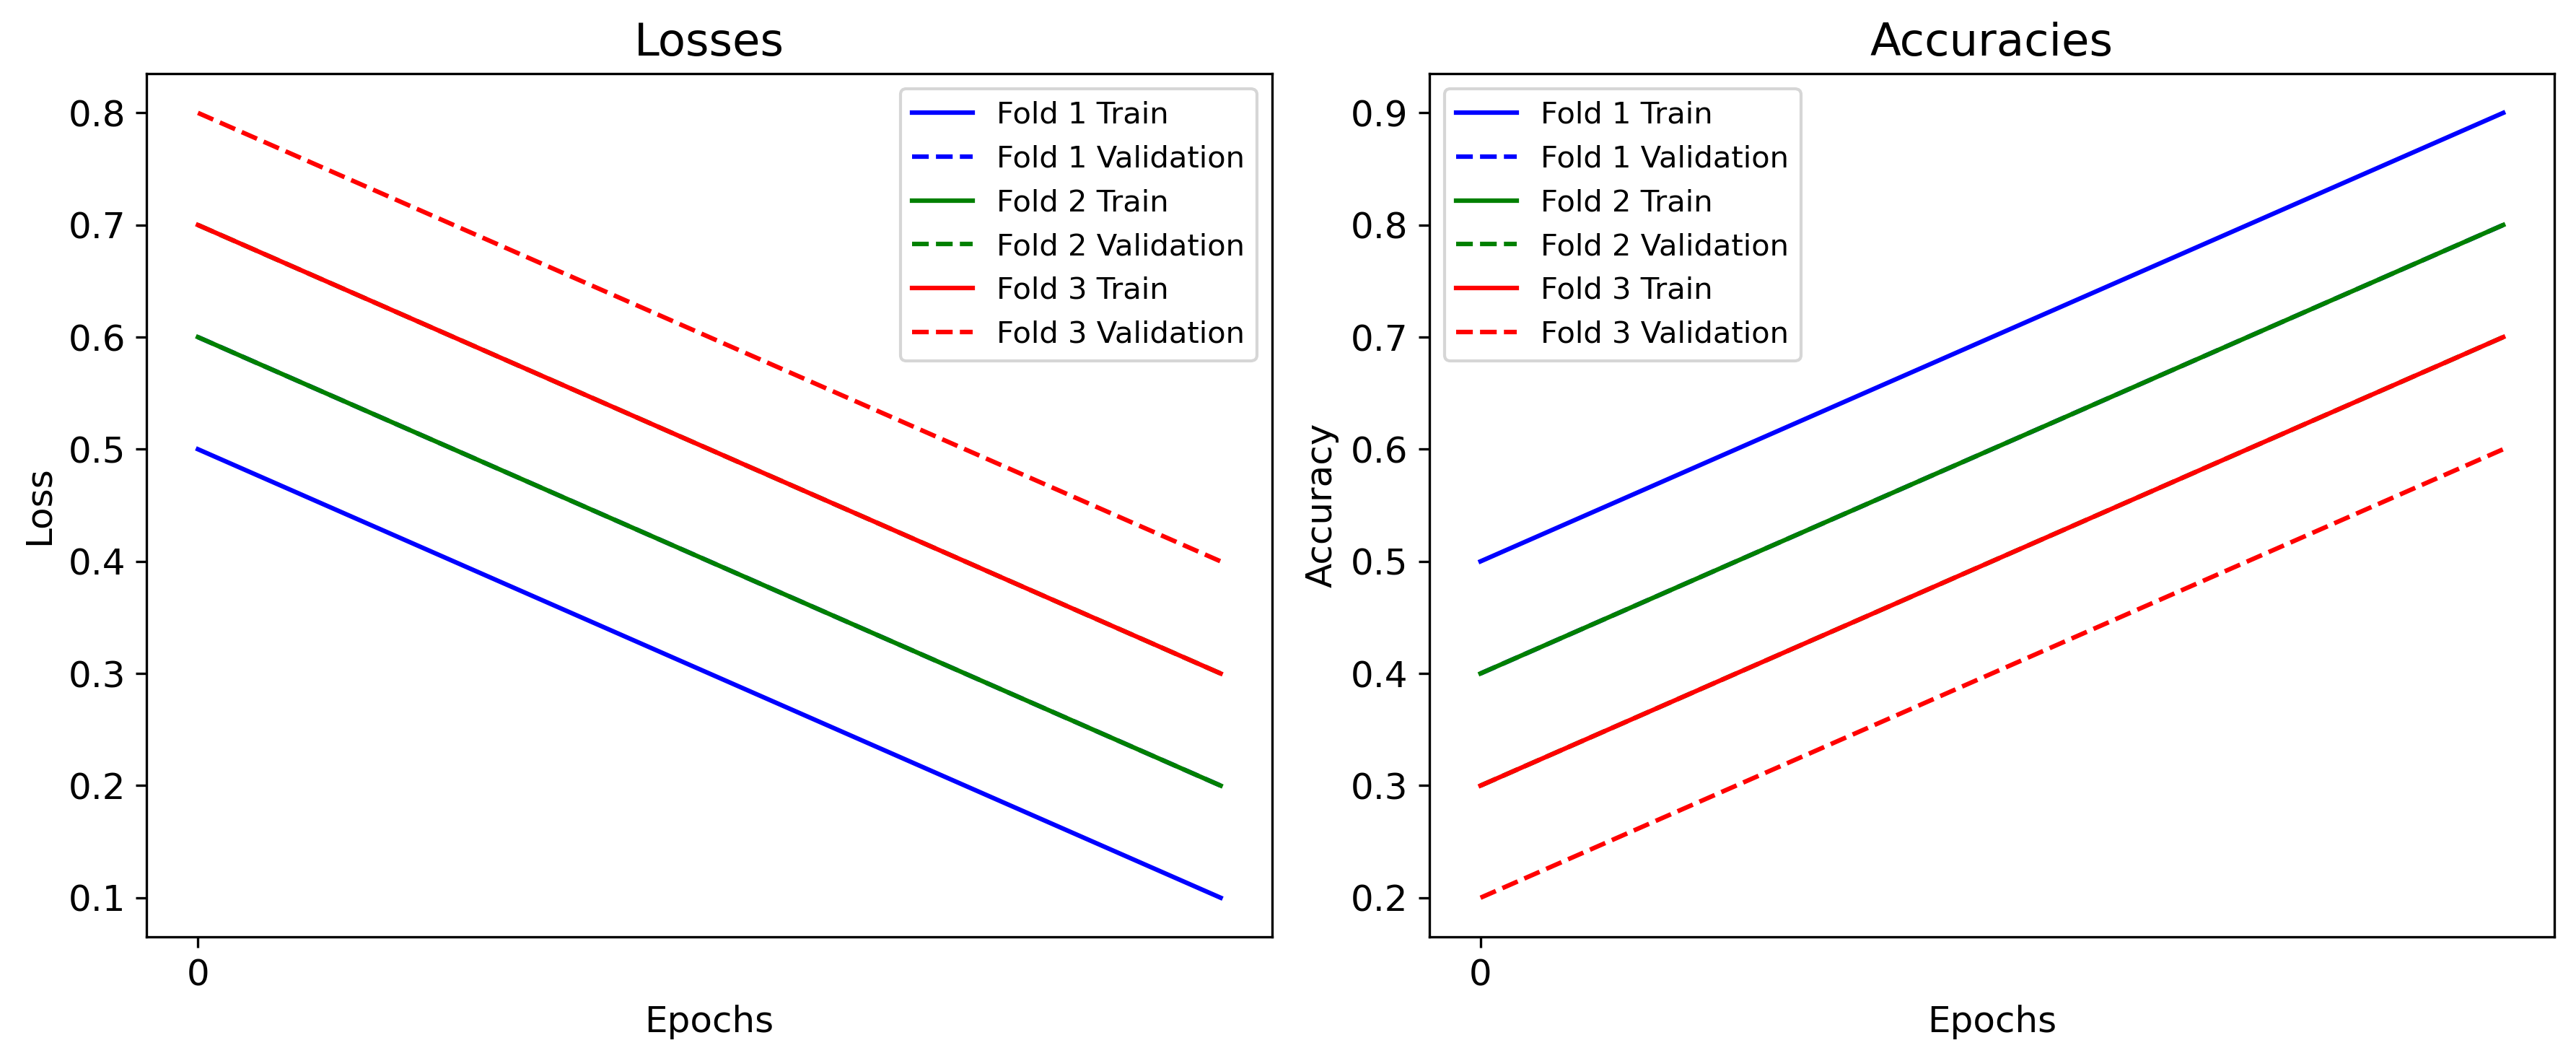

In [76]:
# create synthetic data for the curve plotting function

fold_histories = {'fold_0': {'train_loss_history': [0.5, 0.4, 0.3, 0.2, 0.1], 'val_loss_history': [0.6, 0.5, 0.4, 0.3, 0.2], 'train_acc_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_acc_history': [0.4, 0.5, 0.6, 0.7, 0.8]},
                    'fold_1': {'train_loss_history': [0.6, 0.5, 0.4, 0.3, 0.2], 'val_loss_history': [0.7, 0.6, 0.5, 0.4, 0.3], 'train_acc_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_acc_history': [0.3, 0.4, 0.5, 0.6, 0.7]},
                    'fold_2': {'train_loss_history': [0.7, 0.6, 0.5, 0.4, 0.3], 'val_loss_history': [0.8, 0.7, 0.6, 0.5, 0.4], 'train_acc_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_acc_history': [0.2, 0.3, 0.4, 0.5, 0.6]}}

fold_metrics = {'fold_0': {'train_loss': 0.5097101352612178, 'val_loss': 0.5430395682652791},
                'fold_1': {'train_loss': 0.5133466015259425, 'val_loss': 0.5446163614590963},
                'fold_2': {'train_loss': 0.5096749768654505, 'val_loss': 0.5431361289819082}}

cross_val_metrics = {'train_loss': 0.5112439042172036, 'val_loss': 0.5435970195680945}

out_path = r'E:\Thesis\plots'

save_training_curves_ssl(fold_histories, fold_metrics, cross_val_metrics, out_path)

In [77]:
#load the saved history
import numpy as np

history = np.load(r'E:\Thesis\plots\fold_histories\fold_0_history.npy', allow_pickle=True).item()
history.keys()
print(history['train_loss_history'])

[0.5, 0.4, 0.3, 0.2, 0.1]


In [84]:
def save_training_curves(foldwise_histories, foldwise_best_epoch_metrics, cross_val_metrics, out_path):
    fig, axs = plt.subplots(2,2, figsize= (12,5*2))
    colors = ['b', 'g', 'r']
    for i, (fold, history) in enumerate(foldwise_histories.items()):
        axs[0,0].plot(history['train_loss_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[0,0].plot(history['val_loss_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])

        axs[0,1].plot(history['train_iou_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[0,1].plot(history['val_iou_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])

        axs[1,0].plot(history['train_f1_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[1,0].plot(history['val_f1_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])

        axs[1,1].plot(history['train_accuracy_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[1,1].plot(history['val_accuracy_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])

    axs[0,0].set_title('Dice Loss', fontsize=15)
    axs[0,0].set_xlabel('Epoch', fontsize=12)
    axs[0,0].set_ylabel('Loss', fontsize=12)
    axs[0,0].legend()

    axs[0,1].set_title('IoU', fontsize=15)
    axs[0,1].set_xlabel('Epoch', fontsize=12)
    axs[0,1].set_ylabel('IoU', fontsize=12)
    axs[0,1].legend()

    axs[1,0].set_title('F1 Score', fontsize=15)
    axs[1,0].set_xlabel('Epoch',   fontsize=12)
    axs[1,0].set_ylabel('F1 Score', fontsize=12)
    axs[1,0].legend()

    axs[1,1].set_title('Accuracy', fontsize=15)
    axs[1,1].set_xlabel('Epoch', fontsize=12)
    axs[1,1].set_ylabel('Accuracy', fontsize=12)
    axs[1,1].legend()

    #fontsize ticks increase
    for ax in axs.flatten():
        ax.tick_params(axis='both', which='major', labelsize=12)
        
    # save each history list
    dir_hist = os.path.join(out_path, 'fold_histories')
    os.makedirs(dir_hist, exist_ok=True)
    for key, history in foldwise_histories.items():
        np.save(os.path.join(dir_hist, f'{key}_history.npy'), history)

    max_x_ticks = max([len(history['train_loss_history']) for history in foldwise_histories.values()])
    for ax in axs.flatten():
        ax.set_xticks(np.arange(0, max_x_ticks, step = 5))

    plt.tight_layout()
    plt.savefig(os.path.join(out_path, 'training_curves.png'), dpi=300, pad_inches=0.2, bbox_inches='tight')
    plt.show()
    plt.close()

    # #save fold_metrics in csv
    # index= list(foldwise_best_epoch_metrics['fold_1'].keys())  # get the keys from the first fold
    # metrics = pd.DataFrame(foldwise_best_epoch_metrics, index=index)
    # metrics.to_csv(os.path.join(out_path, 'train_fold_metrics.csv'), index=True, index_label='metric', float_format='%.4f')

    # #save cross_val_metrics in csv

    # metrics = pd.DataFrame(cross_val_metrics,  index=[0])
    # metrics.to_csv(os.path.join(out_path, 'train_cross_val_metrics.csv'), index=False, float_format='%.4f')


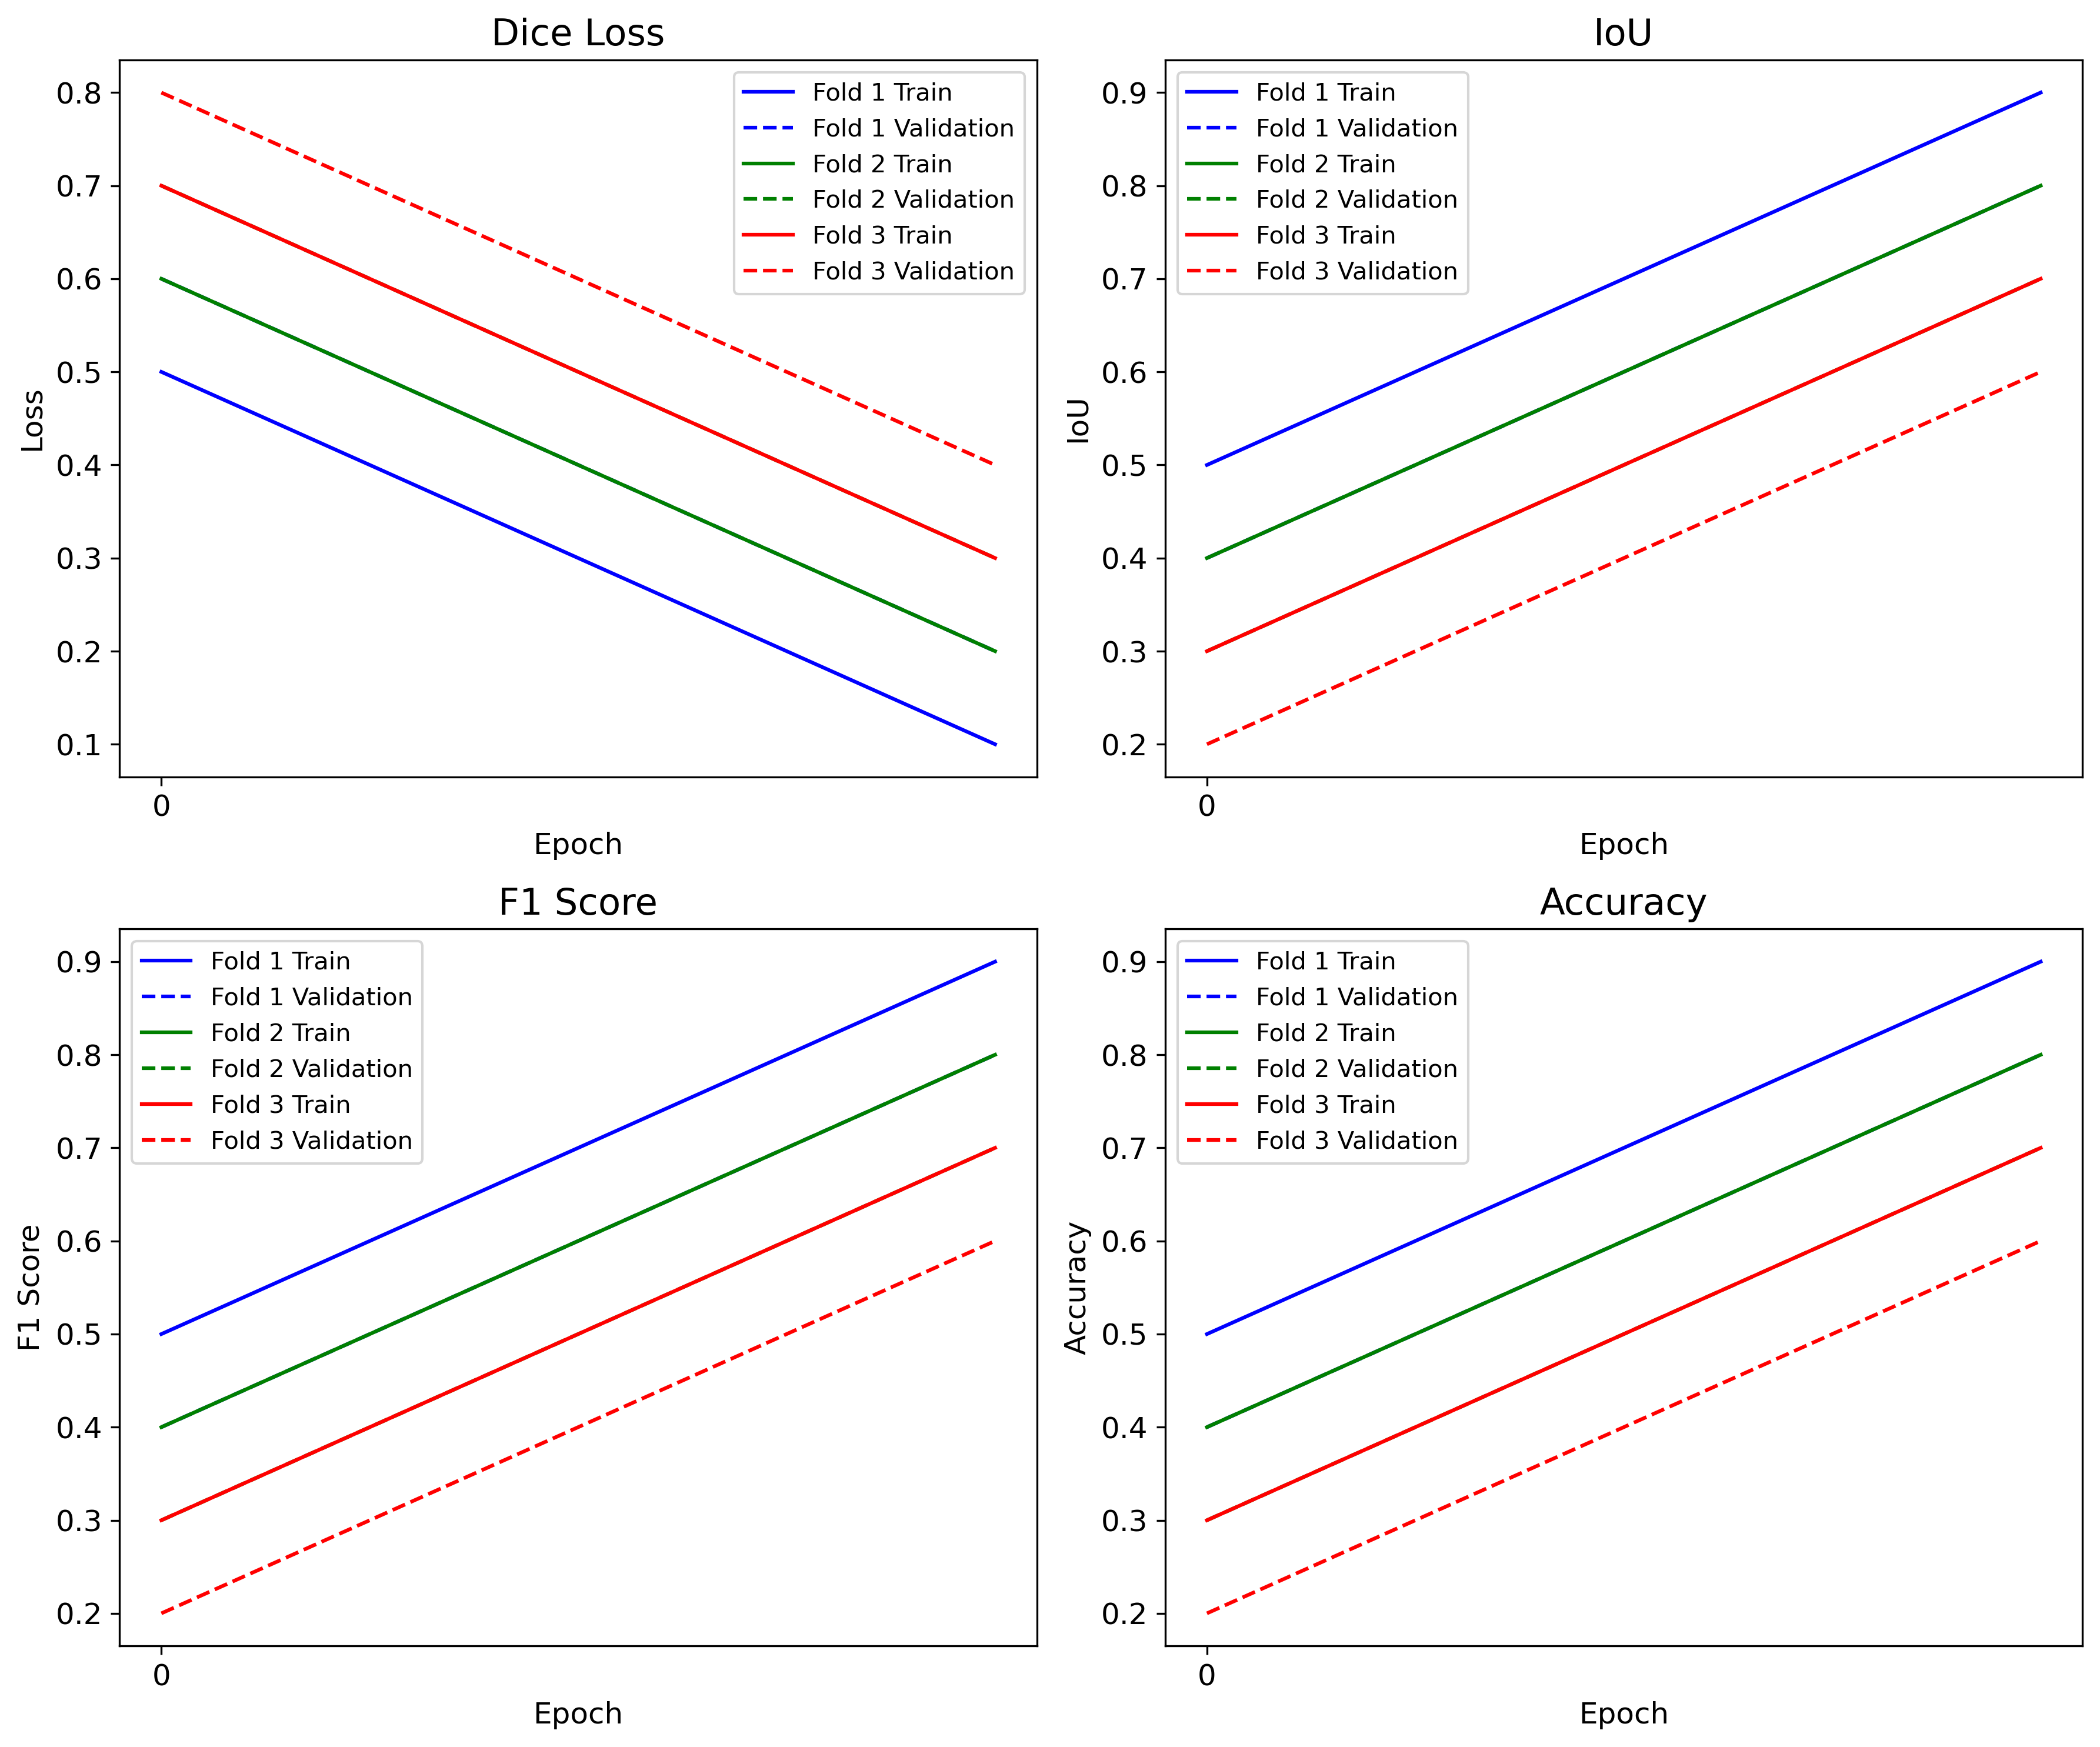

In [85]:
# create synthetic data for the curve plotting function

foldwise_histories = {'fold_0': {'train_loss_history': [0.5, 0.4, 0.3, 0.2, 0.1], 'val_loss_history': [0.6, 0.5, 0.4, 0.3, 0.2], 'train_iou_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_iou_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'train_f1_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_f1_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'train_accuracy_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_accuracy_history': [0.4, 0.5, 0.6, 0.7, 0.8]},
                    'fold_1': {'train_loss_history': [0.6, 0.5, 0.4, 0.3, 0.2], 'val_loss_history': [0.7, 0.6, 0.5, 0.4, 0.3], 'train_iou_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_iou_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'train_f1_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_f1_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'train_accuracy_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_accuracy_history': [0.3, 0.4, 0.5, 0.6, 0.7]},
                    'fold_2': {'train_loss_history': [0.7, 0.6, 0.5, 0.4, 0.3], 'val_loss_history': [0.8, 0.7, 0.6, 0.5, 0.4], 'train_iou_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_iou_history': [0.2, 0.3, 0.4, 0.5, 0.6], 'train_f1_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_f1_history': [0.2, 0.3, 0.4, 0.5, 0.6], 'train_accuracy_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_accuracy_history': [0.2, 0.3, 0.4, 0.5, 0.6]}}
foldwise_best_epoch_metrics = {'fold_0': {'train_loss': 0.5097101352612178, 'val_loss': 0.5430395682652791, 'train_iou': 0.5097101352612178, 'val_iou': 0.5430395682652791, 'train_f1': 0.5097101352612178, 'val_f1': 0.5430395682652791, 'train_accuracy': 0.5097101352612178, 'val_accuracy': 0.5430395682652791},
                'fold_1': {'train_loss': 0.5133466015259425, 'val_loss': 0.5446163614590963, 'train_iou': 0.5133466015259425, 'val_iou': 0.5446163614590963, 'train_f1': 0.5133466015259425, 'val_f1': 0.5446163614590963, 'train_accuracy': 0.5133466015259425, 'val_accuracy': 0.5446163614590963},
                'fold_2': {'train_loss': 0.5096749768654505, 'val_loss': 0.5431361289819082, 'train_iou': 0.5096749768654505, 'val_iou': 0.5431361289819082, 'train_f1': 0.5096749768654505, 'val_f1': 0.5431361289819082, 'train_accuracy': 0.5096749768654505, 'val_accuracy': 0.5431361289819082}}

cross_val_metrics = {'train_loss': 0.5112439042172036, 'val_loss': 0.5435970195680945, 'train_iou': 0.5112439042172036, 'val_iou': 0.5435970195680945, 'train_f1': 0.5112439042172036, 'val_f1': 0.5435970195680945, 'train_accuracy': 0.5112439042172036, 'val_accuracy': 0.5435970195680945}

out_path = r'E:\Thesis\plots'

save_training_curves(foldwise_histories, foldwise_best_epoch_metrics, cross_val_metrics, out_path)

In [86]:
def save_training_curves(best_epoch_nums, foldwise_histories, foldwise_best_epoch_metrics, cross_val_metrics, out_path):
    fig, axs = plt.subplots(2,2, figsize= (12,5*2))
    colors = ['b', 'g', 'r']
    for i, (fold, history) in enumerate(foldwise_histories.items()):
        axs[0,0].plot(history['train_loss_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[0,0].plot(history['val_loss_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])
        axs[0,0].axvline(x=best_epoch_nums[i], color = colors[i], linestyle='-.', label=f"Fold {i+1} Best Epoch")

        axs[0,1].plot(history['train_iou_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[0,1].plot(history['val_iou_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])
        axs[0,1].axvline(x=best_epoch_nums[i], color = colors[i], linestyle='-.', label=f"Fold {i+1} Best Epoch")

        axs[1,0].plot(history['train_f1_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[1,0].plot(history['val_f1_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])
        axs[1,0].axvline(x=best_epoch_nums[i], color = colors[i], linestyle='-.', label=f"Fold {i+1} Best Epoch")

        axs[1,1].plot(history['train_accuracy_history'], label=f"Fold {i+1} Train", color = colors[i])
        axs[1,1].plot(history['val_accuracy_history'], label=f"Fold {i+1} Validation", linestyle='--', color = colors[i])
        axs[1,1].axvline(x=best_epoch_nums[i], color = colors[i], linestyle='-.', label=f"Fold {i+1} Best Epoch")
    
    axs[0,0].set_title('Dice Loss', fontsize=15)
    axs[0,0].set_xlabel('Epoch', fontsize=12)
    axs[0,0].set_ylabel('Loss', fontsize=12)
    axs[0,0].legend()

    axs[0,1].set_title('IoU', fontsize=15)
    axs[0,1].set_xlabel('Epoch', fontsize=12)
    axs[0,1].set_ylabel('IoU', fontsize=12)
    axs[0,1].legend()

    axs[1,0].set_title('F1 Score', fontsize=15)
    axs[1,0].set_xlabel('Epoch', fontsize=12)
    axs[1,0].set_ylabel('F1 Score')
    axs[1,0].legend()

    axs[1,1].set_title('Accuracy', fontsize=15)
    axs[1,1].set_xlabel('Epoch', fontsize=12)
    axs[1,1].set_ylabel('Accuracy', fontsize=12)
    axs[1,1].legend()

    #fontsize ticks increase
    for ax in axs.flatten():
        ax.tick_params(axis='both', which='major', labelsize=12)

    # save each history list
    dir_hist = os.path.join(out_path, 'fold_histories')
    os.makedirs(dir_hist, exist_ok=True)
    for key, history in foldwise_histories.items():
        np.save(os.path.join(dir_hist, f'{key}_history.npy'), history)

    max_x_ticks = max([len(history['train_loss_history']) for history in foldwise_histories.values()])
    for ax in axs.flatten():
        ax.set_xticks(np.arange(0, max_x_ticks, step = 5))

    plt.tight_layout()
    plt.savefig(os.path.join(out_path, 'training_curves.png'), dpi=300,  pad_inches=0.2, bbox_inches='tight')
    plt.show()
    plt.close()

    # #save fold_metrics in csv
    # index= list(foldwise_best_epoch_metrics['fold_1'].keys())  # get the keys from the first fold
    # metrics = pd.DataFrame(foldwise_best_epoch_metrics, index=index)
    # metrics.to_csv(os.path.join(out_path, 'train_fold_metrics.csv'), index=True, index_label='metric', float_format='%.4f')

    # #save cross_val_metrics in csv

    # metrics = pd.DataFrame(cross_val_metrics,  index=[0])
    # metrics.to_csv(os.path.join(out_path, 'train_cross_val_metrics.csv'), index=False, float_format='%.4f')


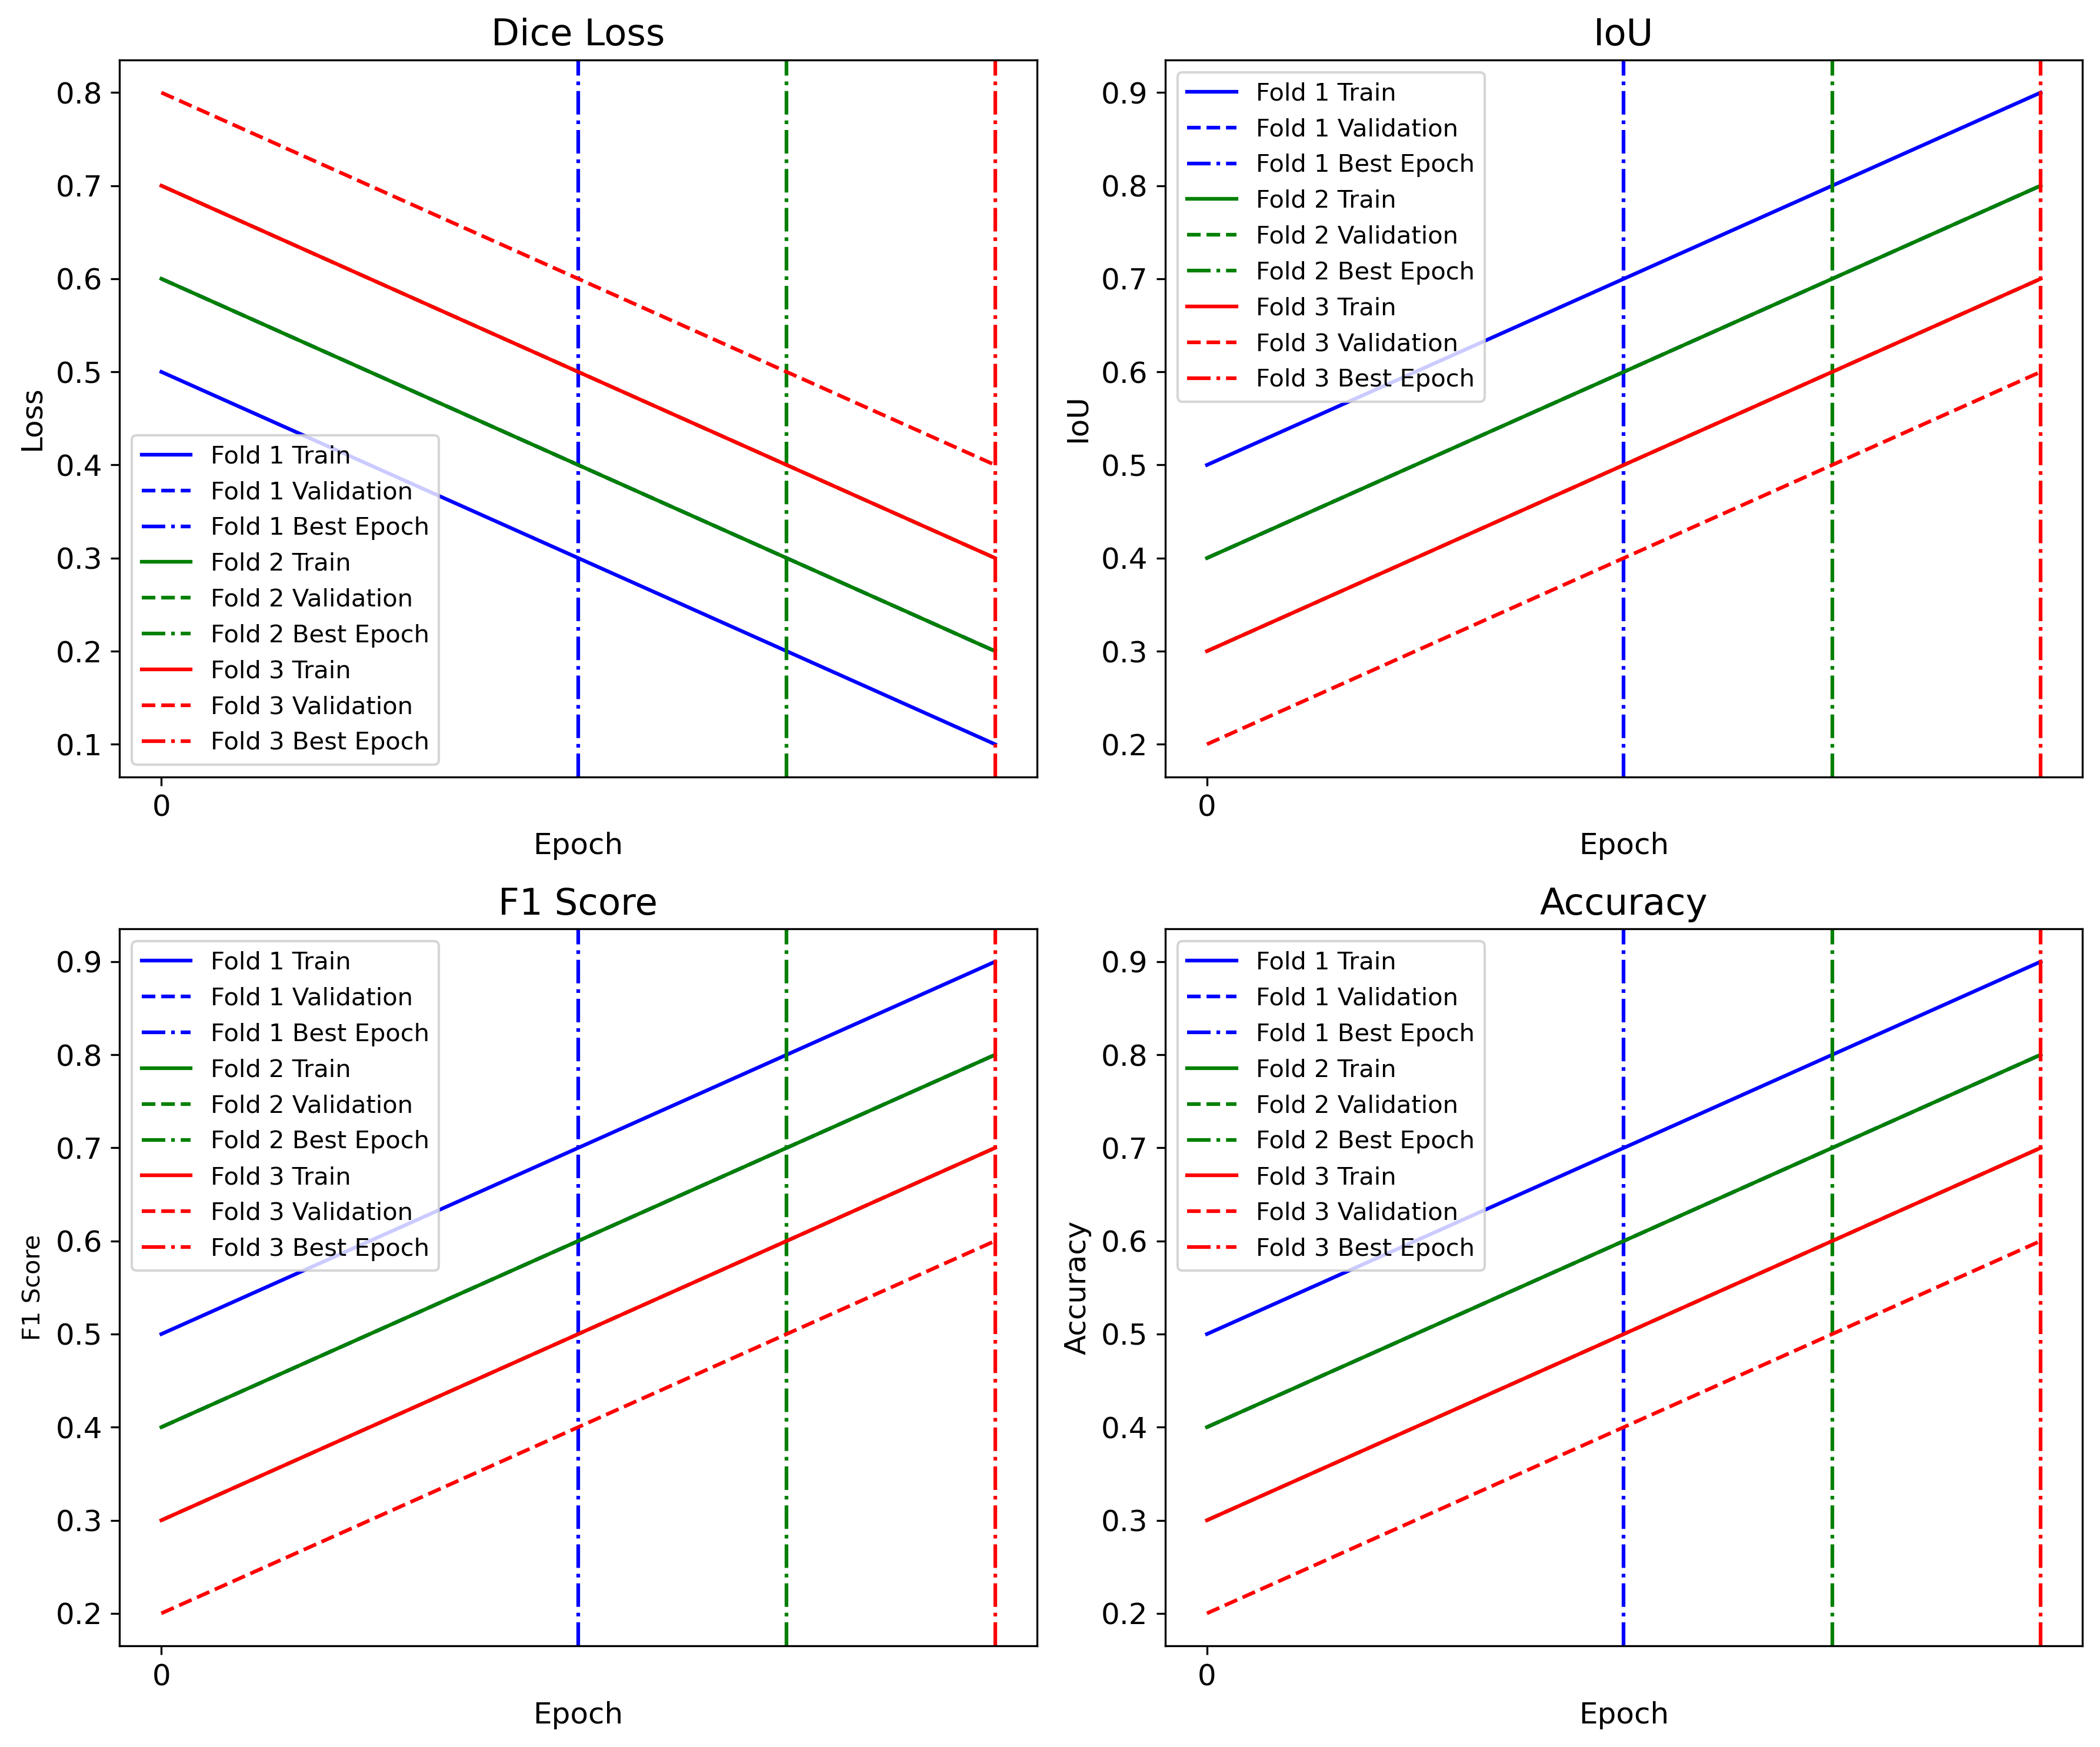

In [87]:
# create synthetic data for the curve plotting function

best_epoch_nums = [2, 3, 4]


foldwise_histories = {'fold_0': {'train_loss_history': [0.5, 0.4, 0.3, 0.2, 0.1], 'val_loss_history': [0.6, 0.5, 0.4, 0.3, 0.2], 'train_iou_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_iou_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'train_f1_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_f1_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'train_accuracy_history': [0.5, 0.6, 0.7, 0.8, 0.9], 'val_accuracy_history': [0.4, 0.5, 0.6, 0.7, 0.8]},
                    'fold_1': {'train_loss_history': [0.6, 0.5, 0.4, 0.3, 0.2], 'val_loss_history': [0.7, 0.6, 0.5, 0.4, 0.3], 'train_iou_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_iou_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'train_f1_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_f1_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'train_accuracy_history': [0.4, 0.5, 0.6, 0.7, 0.8], 'val_accuracy_history': [0.3, 0.4, 0.5, 0.6, 0.7]},
                    'fold_2': {'train_loss_history': [0.7, 0.6, 0.5, 0.4, 0.3], 'val_loss_history': [0.8, 0.7, 0.6, 0.5, 0.4], 'train_iou_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_iou_history': [0.2, 0.3, 0.4, 0.5, 0.6], 'train_f1_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_f1_history': [0.2, 0.3, 0.4, 0.5, 0.6], 'train_accuracy_history': [0.3, 0.4, 0.5, 0.6, 0.7], 'val_accuracy_history': [0.2, 0.3, 0.4, 0.5, 0.6]}}
foldwise_best_epoch_metrics = {'fold_0': {'train_loss': 0.5097101352612178, 'val_loss': 0.5430395682652791, 'train_iou': 0.5097101352612178, 'val_iou': 0.5430395682652791, 'train_f1': 0.5097101352612178, 'val_f1': 0.5430395682652791, 'train_accuracy': 0.5097101352612178, 'val_accuracy': 0.5430395682652791},
                'fold_1': {'train_loss': 0.5133466015259425, 'val_loss': 0.5446163614590963, 'train_iou': 0.5133466015259425, 'val_iou': 0.5446163614590963, 'train_f1': 0.5133466015259425, 'val_f1': 0.5446163614590963, 'train_accuracy': 0.5133466015259425, 'val_accuracy': 0.5446163614590963},
                'fold_2': {'train_loss': 0.5096749768654505, 'val_loss': 0.5431361289819082, 'train_iou': 0.5096749768654505, 'val_iou': 0.5431361289819082, 'train_f1': 0.5096749768654505, 'val_f1': 0.5431361289819082, 'train_accuracy': 0.5096749768654505, 'val_accuracy': 0.5431361289819082}}

cross_val_metrics = {'train_loss': 0.5112439042172036, 'val_loss': 0.5435970195680945, 'train_iou': 0.5112439042172036, 'val_iou': 0.5435970195680945, 'train_f1': 0.5112439042172036, 'val_f1': 0.5435970195680945, 'train_accuracy': 0.5112439042172036, 'val_accuracy': 0.5435970195680945}

out_path = r'E:\Thesis\plots'

save_training_curves(best_epoch_nums, foldwise_histories, foldwise_best_epoch_metrics, cross_val_metrics, out_path)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.contiguous().view(inputs.size(0), -1)
        targets = targets.contiguous().view(targets.size(0), -1)
        intersection = (inputs * targets).sum(dim=1)
        dice = (2. * intersection + self.smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        return 1 - dice.mean()

# Define the shared UNet model
class SharedUNet(nn.Module):
    def __init__(self):
        super(SharedUNet, self).__init__()
        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # This reduces the spatial resolution by half
            # Add more layers as needed
        )
        # Shared decoder with upsampling
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # Upsample to match input resolution
        )
        # Output heads for each task
        self.segmentation_head = nn.Conv2d(32, 1, kernel_size=1)
        self.reconstruction_head = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        seg_output = torch.sigmoid(self.segmentation_head(decoded))
        rec_output = self.reconstruction_head(decoded)
        return seg_output, rec_output

# Define the model
model = SharedUNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the losses
segmentation_loss_fn = DiceLoss()
reconstruction_loss_fn = nn.L1Loss()

# Learnable log variance parameters for uncertainty
log_var_seg = torch.nn.Parameter(torch.zeros((1,), requires_grad=True))
log_var_rec = torch.nn.Parameter(torch.zeros((1,), requires_grad=True))
model_params = list(model.parameters()) + [log_var_seg, log_var_rec]
optimizer = optim.Adam(model_params, lr=0.001)

# Dummy dataloader for illustration
# Replace with your actual dataloader
dataloader = [(
    torch.rand((1, 3, 256, 256)),  # inputs
    torch.randint(0, 2, (1, 1, 256, 256)).float(),  # seg_targets (binary for DiceLoss)
    torch.rand((1, 3, 256, 256))   # rec_targets
) for _ in range(10)]

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, seg_targets, rec_targets in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        seg_outputs, rec_outputs = model(inputs)
        
        # Debug: Print shapes
        print(f"seg_outputs shape: {seg_outputs.shape}, seg_targets shape: {seg_targets.shape}")
        
        # Ensure the shapes are the same
        if seg_outputs.shape != seg_targets.shape:
            print(f"Shape mismatch: seg_outputs shape {seg_outputs.shape}, seg_targets shape {seg_targets.shape}")
            continue
        
        # Compute individual losses
        seg_loss = segmentation_loss_fn(seg_outputs, seg_targets)
        rec_loss = reconstruction_loss_fn(rec_outputs, rec_targets)
        
        # Compute combined loss with uncertainty
        loss = (torch.exp(-log_var_seg) * seg_loss + log_var_seg +
                torch.exp(-log_var_rec) * rec_loss + log_var_rec)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Print or log the current values of log variance parameters
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, '
              f'Seg Loss: {seg_loss.item()}, Rec Loss: {rec_loss.item()}, '
              f'Log Var Seg: {log_var_seg.item()}, Log Var Rec: {log_var_rec.item()}')


seg_outputs shape: torch.Size([1, 1, 256, 256]), seg_targets shape: torch.Size([1, 1, 256, 256])
Epoch [1/50], Loss: 0.9836157560348511, Seg Loss: 0.49538636207580566, Rec Loss: 0.488229364156723, Log Var Seg: -0.0009999998146668077, Log Var Rec: -0.0010000000474974513
seg_outputs shape: torch.Size([1, 1, 256, 256]), seg_targets shape: torch.Size([1, 1, 256, 256])
Epoch [1/50], Loss: 0.9449609518051147, Seg Loss: 0.4897564649581909, Rec Loss: 0.45625796914100647, Log Var Seg: -0.002000251319259405, Log Var Rec: -0.0020011109299957752
seg_outputs shape: torch.Size([1, 1, 256, 256]), seg_targets shape: torch.Size([1, 1, 256, 256])
Epoch [1/50], Loss: 0.8864360451698303, Seg Loss: 0.48077934980392456, Rec Loss: 0.40787839889526367, Log Var Seg: -0.0030011222697794437, Log Var Rec: -0.0030043816659599543
seg_outputs shape: torch.Size([1, 1, 256, 256]), seg_targets shape: torch.Size([1, 1, 256, 256])
Epoch [1/50], Loss: 0.8015771508216858, Seg Loss: 0.4682645797729492, Rec Loss: 0.336897015